In [1]:
import numpy as np
import plotly.graph_objects as go
import plotly.io as pio
pio.templates.default = "seaborn"

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.patches import Rectangle

import sys
sys.path.append("..")
from pygalaxy import Euler_symplectic_tree, ADB6
from pygalaxy import init_solar_system
from pygalaxy.barnes_hut_array import compute_energy_and_tree_structure
#from pygalaxy.naive import compute_energy

((np.float64(-309930000000.0), np.float64(0.0)), np.float64(413240000000.0), np.float64(0.0))
((np.float64(-103310000000.0), np.float64(0.0)), np.float64(206620000000.0), np.float64(0.0))
((np.float64(-309930000000.0), np.float64(0.0)), np.float64(206620000000.0), np.float64(0.0))
((np.float64(-206620000000.0), np.float64(0.0)), np.float64(103310000000.0), np.float64(0.0))
((np.float64(0.0), np.float64(0.0)), np.float64(0.0), np.float64(0.0))
((np.float64(0.0), np.float64(0.0)), np.float64(0.0), np.float64(0.0))
((np.float64(0.0), np.float64(0.0)), np.float64(0.0), np.float64(0.0))
((np.float64(0.0), np.float64(0.0)), np.float64(0.0), np.float64(0.0))
((np.float64(0.0), np.float64(0.0)), np.float64(0.0), np.float64(0.0))
((np.float64(0.0), np.float64(0.0)), np.float64(0.0), np.float64(0.0))
((np.float64(0.0), np.float64(0.0)), np.float64(0.0), np.float64(0.0))
((np.float64(-309930000000.0), np.float64(0.0)), np.float64(413240000000.0), np.float64(0.0))
((np.float64(-103310000000.0), np

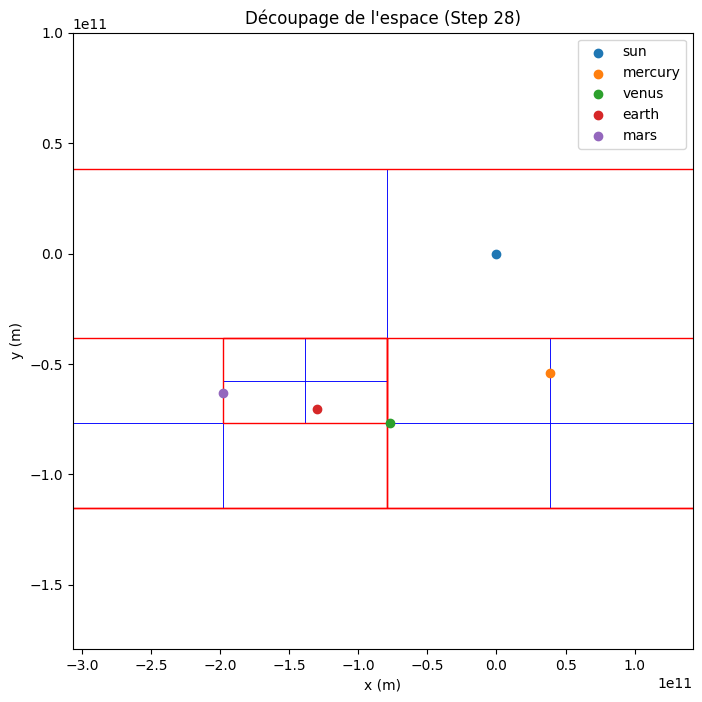

In [4]:
# Simulation parameters
dt = 86400  # 1 day in seconds
nt = 30  # Number of time steps
dim = 2  # Number of dimensions

# Initialize solar system
mass, particles, planets = init_solar_system(dim)

# Number of bodies
nbodies = particles.shape[0]

# Initialize the integrator
time_method = Euler_symplectic_tree(dt, nbodies, dim, compute_energy_and_tree_structure)  # Replace `None` with the appropriate force computation method

# Arrays to store positions and velocities over time
coords = np.zeros((nt, nbodies, dim))
coords[0] = particles[:, :, 0]  # Initial positions

velocities = np.zeros((nt, nbodies, dim))
velocities[0] = particles[:, :, 1]  # Initial velocities

trees = []

# Time-stepping loop
for i in range(nt - 1):
    time_method.update(mass, particles)
    coords[i + 1] = particles[:, :, 0]
    velocities[i + 1] = particles[:, :, 1]
    trees.append(time_method.tree)  # Stocke la structure de l'arbre à chaque étape

# Fonction pour mettre à jour l'animation
def update(frame):
    ax.clear()
    ax.set_title(f"Découpage de l'espace (Step {frame})")
    ax.set_xlim(np.min(coords[:, :, 0]) - 1e11, np.max(coords[:, :, 0]) + 1e11)
    ax.set_ylim(np.min(coords[:, :, 1]) - 1e11, np.max(coords[:, :, 1]) + 1e11)
    ax.set_xlabel("x (m)")
    ax.set_ylabel("y (m)")

    # Récupération de l'arbre pour la frame actuelle
    tree = trees[frame]

    # Dessine les cellules de l'arbre
    for i in range(tree["cell_centers"].shape[0]):
        # Informations sur la cellule mère
        center = tree["cell_centers"][i]
        radius = tree["cell_radii"][i]

        # Calcul des dimensions des sous-rectangles
        sub_radius = radius / 2  # Chaque sous-rectangle a un rayon moitié du parent

        # Coordonnées des centres des 4 sous-rectangles
        sub_centers = [
            (center[0] - sub_radius[0], center[1] - sub_radius[1]),  # Bas-gauche
            (center[0] + sub_radius[0], center[1] - sub_radius[1]),  # Bas-droit
            (center[0] - sub_radius[0], center[1] + sub_radius[1]),  # Haut-gauche
            (center[0] + sub_radius[0], center[1] + sub_radius[1])   # Haut-droit
        ]

        # Dessine les sous-rectangles en bleu
        for sub_center in sub_centers:
            sub_rect = Rectangle(
                (sub_center[0] - sub_radius[0], sub_center[1] - sub_radius[1]),  # Bas-gauche
                2 * sub_radius[0],  # Largeur
                2 * sub_radius[1],  # Hauteur
                edgecolor="blue",  # Couleur des sous-rectangles
                facecolor="none",
                lw=0.5,
            )
            ax.add_patch(sub_rect)

        # Dessine le rectangle mère en rouge
        rect = Rectangle(
            (center[0] - radius[0], center[1] - radius[1]),  # Bas-gauche
            2 * radius[0],  # Largeur
            2 * radius[1],  # Hauteur
            edgecolor="red",  # Couleur du rectangle mère
            facecolor="none",
            lw=1.0,
        )
        ax.add_patch(rect)



    for i in range(len(planets)):
        ax.scatter(coords[frame,i,0], y=coords[frame,i,1], label=planets[i])
    ax.legend(loc="upper right")


# Création de l'animation
fig, ax = plt.subplots(figsize=(8, 8))

ani = FuncAnimation(fig, update, frames=nt - 1, interval=50)

# Sauvegarde en GIF
ani.save("space_partition_evolution.gif", writer="pillow", fps=50)

# Affichage dans le notebook
plt.show()
